In [17]:
# Open the data

import numpy as np
import csv
from dask import dataframe as df1
import time
import pandas as pd

dataPath = 'InsideAirBNBData/listings.csv'

start = time.time()
df = pd.read_csv(dataPath)
end = time.time()
print("Read csv without chunks: ",(end-start),"sec")

Read csv without chunks:  1.596991777420044 sec


/Users/cole/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Filtering Data

Filter out relevant data and remove inactive listings


In [346]:
print(df.dtypes)
print(df['scrape_id'])

# Convert super host t/f to int
df.host_is_superhost.replace(('t', 'f'), (1, 0), inplace=True)

# Filter out Na or NaN values for last review date
filterNaN = df[df.last_review.notnull()]

# Filter out properties with no reviews in 2022
filterlastreview = filterNaN[filterNaN.last_review.str.startswith("2022")]

# Filter to only short term rental properties
filterShortTermProperties = filterlastreview[filterlastreview.minimum_nights < 30]

# Filter to only reasonable priced properties and ones that have some availability
# Remove dollar signs
pd.options.mode.chained_assignment = None  # default='warn'# Supress warnings
filterShortTermProperties['price'] = filterShortTermProperties['price'].str.replace(',', '')
filterShortTermProperties['price'] = filterShortTermProperties['price'].str.replace('$', '')
filterShortTermProperties['price'] = filterShortTermProperties['price'].astype(float)

filterReasonablePrice = filterShortTermProperties[(filterShortTermProperties.price > 0)]
filteredProperties = filterReasonablePrice[(filterShortTermProperties.availability_30 > 0) | (filterShortTermProperties.availability_60 > 0) | (filterShortTermProperties.availability_90 > 0)]

print("Filtered down to ",filteredProperties.shape[0],"of ",df.shape[0]," properties")

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
name                                             object
description                                      object
neighborhood_overview                            object
picture_url                                      object
host_id                                           int64
host_url                                         object
host_name                                        object
host_since                                       object
host_location                                    object
host_about                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                            

/var/folders/pq/vfbygzds5rd9ybhnrslknkk40000gp/T/ipykernel_88631/3830458023.py:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  filterShortTermProperties['price'] = filterShortTermProperties['price'].str.replace('$', '')
/var/folders/pq/vfbygzds5rd9ybhnrslknkk40000gp/T/ipykernel_88631/3830458023.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filteredProperties = filterReasonablePrice[(filterShortTermProperties.availability_30 > 0) | (filterShortTermProperties.availability_60 > 0) | (filterShortTermProperties.availability_90 > 0)]


In [163]:
# print(filterShortTermProperties.availability_30.describe())
filteredProperties = filterShortTermProperties.sort_values(by=['availability_30'])


# print(sortedAvailability.iloc[13000])
# filteredProperties.availability_30.describe()

print(filteredProperties.bathrooms)


4       NaN
24935   NaN
24933   NaN
24922   NaN
24918   NaN
         ..
22309   NaN
31204   NaN
28035   NaN
33509   NaN
34121   NaN
Name: bathrooms, Length: 15231, dtype: float64


In [336]:
# Show correlation in features
import matplotlib as mpl 

corr = filteredProperties.corr();
print(corr.columns)
corr.style.background_gradient(cmap='coolwarm')

Index(['id', 'scrape_id', 'host_id', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_co

/Users/cole/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/cole/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,id,scrape_id,host_id,host_is_superhost,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,1.000000,nan,0.298693,-0.226457,-0.044368,-0.019874,0.012163,0.072516,0.026492,nan,0.035638,-0.005095,0.006052,-0.110128,-0.132232,-0.106210,-0.078430,-0.025115,-0.026234,-0.103872,-0.025753,nan,0.123368,0.140111,0.140223,0.133725,-0.345765,-0.275271,0.038629,-0.047707,-0.061070,-0.038030,-0.068657,-0.048507,-0.074983,-0.033094,-0.088433,-0.080454,-0.042164,0.080712,0.095159
scrape_id,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
host_id,0.298693,nan,1.000000,-0.131807,-0.011431,-0.015860,0.040810,0.111588,0.073325,nan,0.037776,0.042371,0.012521,-0.162719,-0.036443,-0.161870,-0.115259,0.016948,0.018017,-0.145022,0.017489,nan,0.244678,0.267547,0.271664,0.160542,-0.237753,0.003887,0.086464,-0.141451,-0.138132,-0.099233,-0.146804,-0.153958,-0.114797,-0.126237,0.033213,-0.015700,0.119103,-0.004376,0.169789
host_is_superhost,-0.226457,nan,-0.131807,1.000000,0.027571,-0.018506,-0.047590,-0.014531,-0.000208,nan,0.006432,0.023666,0.003808,0.009987,-0.001094,-0.003337,-0.013840,-0.016744,-0.018816,-0.002355,-0.017634,nan,-0.132777,-0.136233,-0.124582,-0.101764,0.215999,0.199306,0.093737,0.274615,0.240956,0.271379,0.217120,0.221922,0.139441,0.235324,0.131769,0.135433,0.030921,-0.067006,0.078500
host_listings_count,-0.044368,nan,-0.011431,0.027571,1.000000,0.932812,0.016268,-0.081176,-0.008928,nan,-0.031367,-0.019923,0.092949,-0.012961,-0.011909,-0.016627,0.026816,-0.001026,-0.001334,-0.010478,-0.001144,nan,0.084748,0.088158,0.081088,-0.003108,-0.038659,-0.001538,-0.039634,-0.011376,-0.022586,0.004378,-0.038886,-0.036473,0.026957,-0.024849,0.453821,0.390718,0.247193,0.007695,-0.010664
host_total_listings_count,-0.019874,nan,-0.015860,-0.018506,0.932812,1.000000,0.014041,-0.059600,0.003313,nan,-0.012756,-0.004947,0.091312,-0.015030,-0.003482,-0.015215,0.011043,-0.001733,-0.001942,-0.013359,-0.001823,nan,0.072146,0.070552,0.063543,0.023893,-0.021655,0.007309,-0.025513,-0.014029,-0.022466,-0.002967,-0.049630,-0.032507,0.018071,-0.020470,0.257832,0.189296,0.216455,-0.000095,0.002975
latitude,0.012163,nan,0.040810,-0.047590,0.016268,0.014041,1.000000,0.058303,-0.066149,nan,-0.096911,-0.077980,0.020369,0.005743,0.013135,-0.006483,0.015249,0.019675,0.020478,0.009617,0.020149,nan,-0.052232,-0.047854,-0.050207,-0.036247,-0.016567,-0.008984,-0.001404,-0.048429,-0.051680,-0.061750,-0.059048,-0.046382,0.017071,-0.045813,0.005661,0.001765,0.003263,0.043911,-0.014974
longitude,0.072516,nan,0.111588,-0.014531,-0.081176,-0.059600,0.058303,1.000000,0.030626,nan,0.047369,0.025425,-0.180617,-0.094970,-0.029156,-0.071335,-0.087572,-0.020043,-0.022252,-0.101327,-0.021013,nan,0.238317,0.280966,0.279176,0.169701,-0.034807,-0.030174,0.041793,-0.002428,0.005912,0.024240,0.014862,0.008453,-0.138213,0.019994,-0.151465,-0.121864,-0.095743,-0.017846,0.025131
accommodates,0.026492,nan,0.073325,-0.000208,-0.008928,0.003313,-0.066149,0.030626,1.000000,nan,0.777090,0.803320,0.417702,-0.082403,0.055139,-0.085817,-0.026953,-0.017152,-0.018491,-0.058135,-0.017790,nan,0.131389,0.071486,0.061834,0.099623,-0.004016,0.023165,0.018533,-0.002716,-0.013840,0.008283,0.022

In [339]:
# Split dataset into training and testing
from sklearn.model_selection import train_test_split

# Filter out uneeded columns and drop NaN rows
data_columns = filteredProperties[['accommodates','bedrooms','beds','number_of_reviews','price','review_scores_rating','availability_30']]
data_clean = data_columns.dropna()

X = data_clean[['accommodates','bedrooms','beds','number_of_reviews','review_scores_rating','price']]
Y = data_clean['availability_30']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

In [340]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error

model_SVR = svm.SVR()
model_SVR.fit(X_train, Y_train)
Y_pred = model_SVR.predict(X_test)

print(mean_absolute_percentage_error(Y_test, Y_pred))

3612445120313405.5


In [341]:
Y_np = Y_test.to_numpy().reshape(-1,1)
Y_pred = Y_pred.reshape(-1,1)

Y_comp = np.hstack((Y_pred,Y_np))

print(Y_comp)

[[ 6.70003674 12.        ]
 [ 7.89476218 30.        ]
 [ 8.16225404  9.        ]
 ...
 [12.86549156  0.        ]
 [ 4.98408089  6.        ]
 [ 8.37880927 10.        ]]


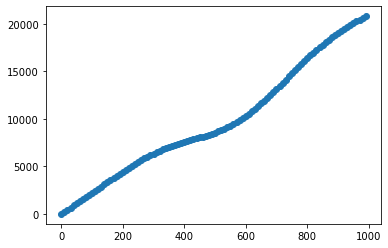

7.470344141678696


In [342]:
# Graph relation of price to expected availability
import matplotlib.pyplot as plt

samples = np.tile(np.array([2,1,1,10,4]), (100,1))
prices = np.arange(0,1000,10).reshape(-1,1)
testX = np.hstack((samples,prices))

y_test = model_SVR.predict(testX)
y_rev = np.multiply(30-y_test.reshape(-1,1), prices)
plt.scatter(prices,y_rev)
plt.show()

print(y_test[1])

#######
# Model is inconclusive, esssentially same result regardless of price


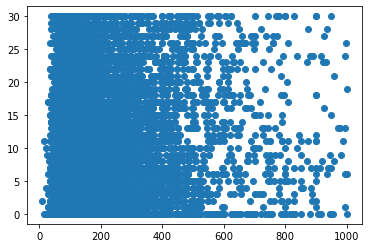

In [300]:
data_filtered = data_clean[data_clean.price < 1000]

plt.scatter(data_filtered['price'], data_filtered['availability_30'])
plt.show()

In [321]:
# Predicting price instead of occupancy?

from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error

# Filter out uneeded columns and drop NaN rows
data_columns = filteredProperties[['accommodates','bedrooms','beds','number_of_reviews','price','review_scores_rating']]
data_clean = data_columns.dropna()

X = data_clean[['accommodates','bedrooms','beds','number_of_reviews','review_scores_rating']]
Y = data_clean['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

model_SVR = svm.SVR()
model_SVR.fit(X_train, Y_train)
Y_pred = model_SVR.predict(X_test)

print(mean_absolute_percentage_error(Y_test, Y_pred))

0.574754950401441


# Using NN 

In [374]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Format Dataset
relevant_columns = filteredProperties[['accommodates','bedrooms','beds','price','review_scores_rating','host_is_superhost','reviews_per_month']]
relevant_columns_clean = relevant_columns.dropna()
data = relevant_columns_clean.values

# Test by overfitting
X = data[:,0:6]
Y = data[:,6]
# X = data[0:20,0:6]
# Y = data[0:20,6]
# Normalize data
min_max_scaler = preprocessing.MinMaxScaler()
X_norm = min_max_scaler.fit_transform(X)

# Split data into train, validate and test datasets
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_norm, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [375]:
from keras.models import Sequential
from keras.layers import Dense

# Create network
model = Sequential([
    Dense(32, activation='relu', input_shape=(6,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

# Compile
model.compile(optimizer='sgd',
              loss='mean_absolute_percentage_error',
              metrics=['accuracy'])

# Train
model.fit(X_train, Y_train,
          batch_size=32, epochs=100,
          validation_data=(X_val, Y_val))

Epoch 1/100
267/267 [==============================] - 1s 3ms/step - loss: 73.5467 - accuracy: 0.0202 - val_loss: 70.4851 - val_accuracy: 0.0312
Epoch 2/100
267/267 [==============================] - 1s 3ms/step - loss: 72.9770 - accuracy: 0.0158 - val_loss: 70.4651 - val_accuracy: 0.0093
Epoch 3/100
267/267 [==============================] - 1s 3ms/step - loss: 72.9197 - accuracy: 0.0141 - val_loss: 70.2591 - val_accuracy: 0.0104
Epoch 4/100
267/267 [==============================] - 1s 3ms/step - loss: 72.8136 - accuracy: 0.0155 - val_loss: 70.6654 - val_accuracy: 0.0361
Epoch 5/100
267/267 [==============================] - 1s 2ms/step - loss: 72.7091 - accuracy: 0.0200 - val_loss: 69.8894 - val_accuracy: 0.0186
Epoch 6/100
267/267 [==============================] - 1s 3ms/step - loss: 72.4818 - accuracy: 0.0190 - val_loss: 70.9327 - val_accuracy: 0.0093
Epoch 7/100
267/267 [==============================] - 1s 3ms/step - loss: 72.2826 - accuracy: 0.0180 - val_loss: 73.6874 - val_ac

267/267 [==============================] - 0s 2ms/step - loss: 71.5426 - accuracy: 0.0136 - val_loss: 74.4051 - val_accuracy: 0.0055
Epoch 58/100
267/267 [==============================] - 0s 2ms/step - loss: 71.8011 - accuracy: 0.0134 - val_loss: 71.2248 - val_accuracy: 0.0066
Epoch 59/100
267/267 [==============================] - 1s 2ms/step - loss: 71.5821 - accuracy: 0.0190 - val_loss: 70.8726 - val_accuracy: 0.0071
Epoch 60/100
267/267 [==============================] - 1s 2ms/step - loss: 71.9956 - accuracy: 0.0184 - val_loss: 70.7048 - val_accuracy: 0.0099
Epoch 61/100
267/267 [==============================] - 1s 2ms/step - loss: 71.4398 - accuracy: 0.0150 - val_loss: 70.1920 - val_accuracy: 0.0120
Epoch 62/100
267/267 [==============================] - 0s 2ms/step - loss: 71.6897 - accuracy: 0.0149 - val_loss: 70.6214 - val_accuracy: 0.0093
Epoch 63/100
267/267 [==============================] - 0s 2ms/step - loss: 71.8637 - accuracy: 0.0154 - val_loss: 69.6267 - val_accuracy